In [9]:
!pip list

Package                            Version
---------------------------------- --------------------
absl-py                            1.4.0
accelerate                         1.2.1
aiohappyeyeballs                   2.4.4
aiohttp                            3.11.10
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.19
albumentations                     1.4.20
altair                             5.5.0
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.20.0
astropy                            6.1.7
astropy-iers-data                  0.2024.12.16.0.35.48
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic                           4.1.0
attrs                              24.3.0
audioread        

In [1]:
!pip install torch torchvision lime scikit-image matplotlib --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries, slic
import numpy as np
from lime import lime_image
import torch
import numpy as np
from skimage.segmentation import slic, mark_boundaries
from skimage.color import gray2rgb
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # The fully connected layer needs the correct input size after pooling
        self.fc = nn.Linear(7*7*32, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)  # Use reshape instead of view
        out = self.fc(out)
        return out

In [4]:
# Set up training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 5
batch_size = 64
learning_rate = 0.001

# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 49.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 3.90MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.8MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.48MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# Model, loss, and optimizer
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
print("Starting training...")
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Evaluation
print("Evaluating model...")
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")

Starting training...
Epoch [1/5], Loss: 0.1286
Epoch [2/5], Loss: 0.0482
Epoch [3/5], Loss: 0.0356
Epoch [4/5], Loss: 0.0290
Epoch [5/5], Loss: 0.0254
Evaluating model...
Accuracy on test set: 98.93%


In [7]:
torch.save(model.state_dict(), 'mnist_convnet.pth')

  0%|          | 0/1000 [00:00<?, ?it/s]

Top Labels for Digit: [0]


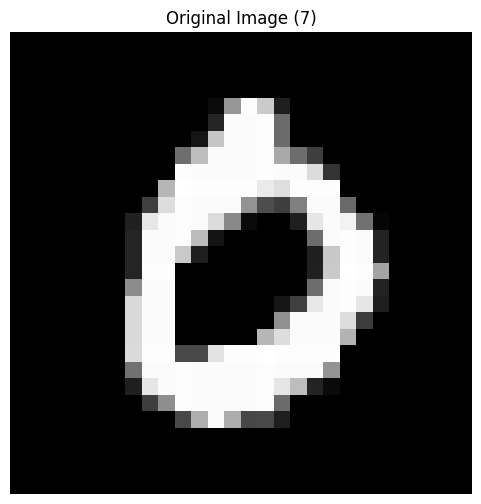

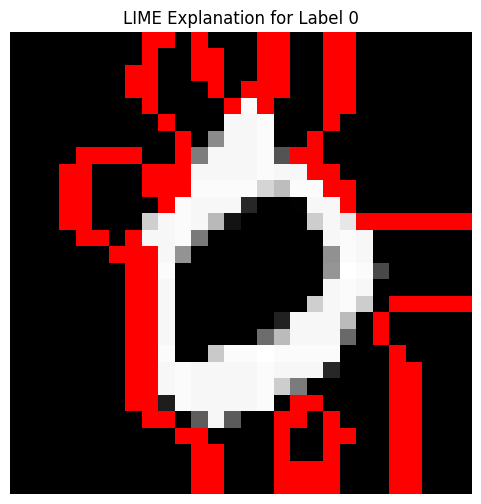

In [8]:
# Define the predict_proba function compatible with LIME
def predict_proba(images):
    """
    Converts RGB images from LIME to PyTorch-compatible grayscale tensors,
    performs inference, and converts predictions back to NumPy arrays.
    """
    model.eval()
    images = torch.tensor(images).float()  # Convert to PyTorch tensor
    images = images.mean(dim=-1, keepdim=True)  # Convert RGB to grayscale (average R, G, B channels)
    images = images.permute(0, 3, 1, 2)  # Change shape from [batch_size, 28, 28, 1] to [batch_size, 1, 28, 28]
    with torch.no_grad():
        outputs = model(images)  # Run inference
    return F.softmax(outputs, dim=1).cpu().numpy()  # Convert back to NumPy for LIME

# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Define a custom segmentation function for small images
def segmentation_fn(image):
    """
    Applies SLIC segmentation to create superpixels.
    Adjust `n_segments` and `compactness` as needed.
    """
    return slic(image, n_segments=50, compactness=1, start_label=1)

# Fetch a single batch of data from the test_loader
data_iter = iter(test_loader)
images, labels = next(data_iter)  # Get a batch of images and labels

# Select a single image from the batch
example_image = images[3]  # Choose the first image in the batch

# Convert the image from grayscale (28, 28) to RGB (28, 28, 3)
example_image_rgb = example_image.numpy().transpose(1, 2, 0)  # Convert to (28, 28, 1) -> (28, 28, 3)
example_image_rgb = np.repeat(example_image_rgb, 3, axis=-1)  # Repeat grayscale channels to form RGB

# Explain the individual prediction for the selected image
explanation = explainer.explain_instance(
    example_image_rgb,  # Input image in RGB format
    predict_proba,      # Prediction function
    top_labels=1,       # Number of labels to explain
    hide_color=0,       # Background color for superpixels
    num_samples=1000,   # Number of perturbations
    segmentation_fn=segmentation_fn  # Custom segmentation
)

# Check the top labels to use a valid one for visualization
print(f"Top Labels for Digit: {explanation.top_labels}")  # Dynamically pick a top label if needed
top_label = explanation.top_labels[0]  # Use the highest-probability label

# Visualize the explanation with enhanced settings
temp, mask = explanation.get_image_and_mask(
    label=top_label,  # Dynamically choose a label
    positive_only=False,  # Highlight both positive and negative contributions
    num_features=10,      # Increase the number of features highlighted
    hide_rest=False       # Show the rest of the image for context
)

# Display the original image
plt.figure(figsize=(6, 6))
plt.imshow(example_image.numpy().squeeze(), cmap='gray')  # Display grayscale image
plt.title(f"Original Image ({labels[0]})")  # Display the true label
plt.axis('off')
plt.show()

# Display the image with boundaries
plt.figure(figsize=(6, 6))
plt.imshow(mark_boundaries(gray2rgb(example_image.numpy().squeeze()), mask, color=(1, 0, 0)))
plt.title(f"LIME Explanation for Label {top_label}")
plt.axis('off')
plt.show()